In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

from maelstrom.maelstrom import Maelstrom
from maelstrom.estimator import estimate_frequencies

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [42]:
# kicid = 6862920
kicid = 9837267

data = np.loadtxt("data/kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("data/kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6]

orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

In [43]:
nu = estimate_frequencies(times, dmmags)
nu

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 38089.061511
  Number of iterations: 17
  Number of functions evaluations: 22


array([ 16.67621704,  16.13234069,  19.56835592,  22.80438406,
        22.05048247,  19.80571476])

In [44]:
tmax = times.max()
tmin = times.min()
dt = np.median(np.diff(times))
df = 1.0 / (tmax - tmin)
ny = 0.5 / dt

freq = np.arange(df, 2*ny, df/4.)
print(df, freq.shape)
power = LombScargle(times, dmmags).power(freq)

0.000680058186872 (287848,)


In [45]:
# Find and fit peaks
max_peaks = 6
peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
peak_inds = np.arange(1, len(power)-1)[peak_inds]
peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
peaks = []
for j in range(max_peaks):
    i = peak_inds[0]
    freq0 = freq[i]
    alias = 2.0*ny - freq0
    
    m = np.abs(freq[peak_inds] - alias) > 10*df
    m &= np.abs(freq[peak_inds] - freq0) > 10*df

    peak_inds = peak_inds[m]
    peaks.append((freq0, power[i]))

peaks = np.array(peaks)
peaks

array([[  1.66762168e+01,   8.57686195e-01],
       [  1.61323403e+01,   2.49299186e-02],
       [  1.95683343e+01,   1.17967807e-02],
       [  2.28043912e+01,   9.00204742e-03],
       [  2.20505467e+01,   6.63775181e-03],
       [  1.98056746e+01,   5.37187040e-03]])

In [46]:
nu_arr

array([ 16.67621704,  16.13234063,  19.56835588,  22.80438341])

In [47]:
delta = np.abs(nu_arr[:, None] - peaks[:, 0][None, :])
np.min(delta, axis=0), np.min(delta, axis=1)

(array([  1.95071429e-07,   3.20022316e-07,   2.15858515e-05,
          7.77137892e-06,   7.53836729e-01,   2.37318721e-01]),
 array([  1.95071429e-07,   3.20022316e-07,   2.15858515e-05,
          7.77137892e-06]))

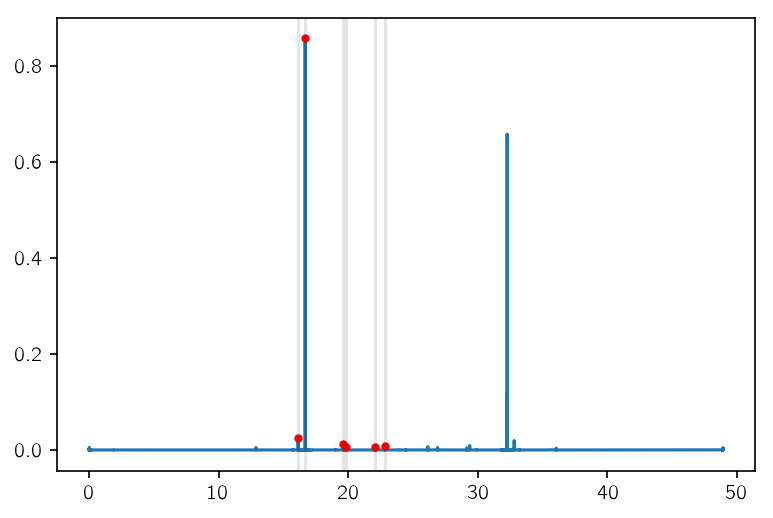

In [48]:
plt.plot(freq, power)
plt.plot(peaks[:, 0], peaks[:, 1], ".r")
for n in nu:
    plt.axvline(n, color="k", alpha=0.1)
# plt.xlim(df, ny)
# plt.yscale("log")

In [66]:
model = Maelstrom(times, dmmags, nu)
model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

In [67]:
model.get_session().run(model.chi2)

38085.273367359936

In [68]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 38085.273366
  Number of iterations: 1
  Number of functions evaluations: 5


In [69]:
model.optimize([model.period, model.tref])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 38085.194818
  Number of iterations: 11
  Number of functions evaluations: 13


In [70]:
model.optimize([model.period, model.tref, model.lighttime])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 38084.463516
  Number of iterations: 11
  Number of functions evaluations: 15


In [71]:
model.get_lighttime_estimates()

[array([  4.90129799e-05,  -4.20878778e-05,   2.68838991e-06,
          5.21887198e-06,  -4.13122847e-05,   2.40097415e-05]),
 array([  1.86349685e+09,   5.04403176e+07,   3.57856724e+07,
          3.62517310e+07,   2.55353447e+07,   1.67680726e+07])]

In [72]:
model.pin_lighttime_values()

(array([0, 0, 0, 0, 0, 0], dtype=int32), array([  4.38035027e-05]))

In [73]:
model.get_lighttime_estimates()

[array([  4.38035027e-05,   4.38035027e-05,   4.38035027e-05,
          4.38035027e-05,   4.38035027e-05,   4.38035027e-05]),
 array([  1.86350556e+09,   5.04356360e+07,   3.57848561e+07,
          3.62481561e+07,   2.55320746e+07,   1.67682363e+07])]

In [86]:
model.optimize([model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30087.394518
  Number of iterations: 1
  Number of functions evaluations: 3


In [87]:
model.optimize([model.period, model.log_sigma2, model.tref, model.lighttime, model.eccen_param, model.varpi])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30087.394518
  Number of iterations: 1
  Number of functions evaluations: 4


In [88]:
model.optimize([model.nu])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30087.394518
  Number of iterations: 1
  Number of functions evaluations: 4


In [89]:
model.nu_data - model.get_session().run(model.nu)

array([ -7.68601183e-10,   1.69242753e-09,  -1.79044690e-09,
        -1.52677870e-10,  -1.43625556e-10,  -2.38552644e-09])

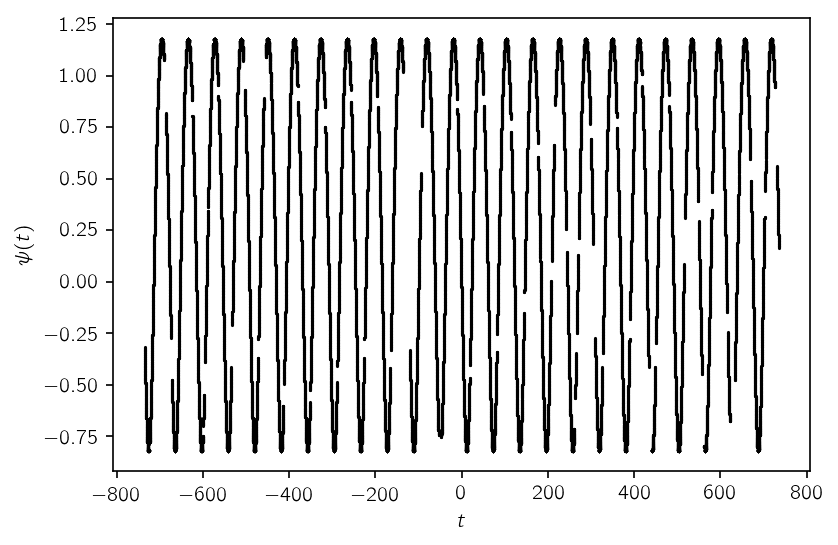

In [90]:
plt.plot(times, model.run(model.psi), ".k", ms=1)
plt.ylabel("$\psi(t)$")
plt.xlabel("$t$");

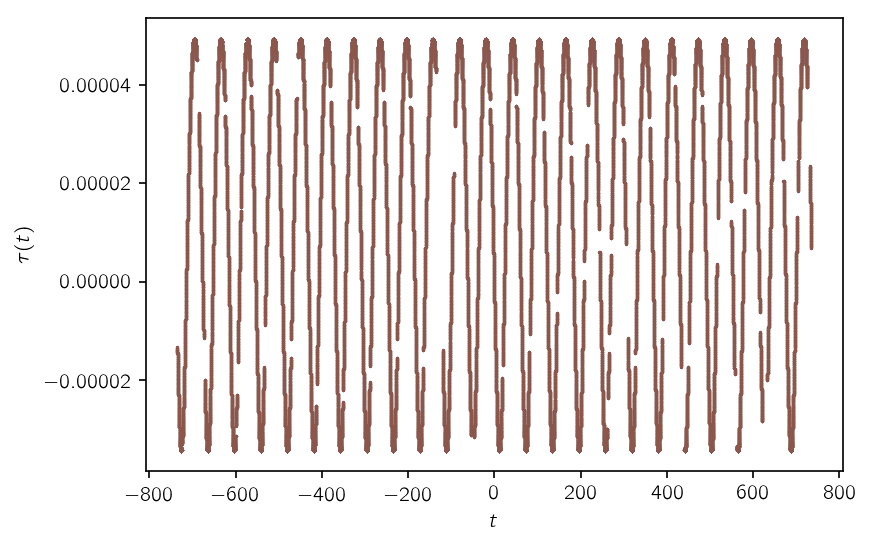

In [91]:
plt.plot(times, model.run(model.tau), ".", ms=1)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

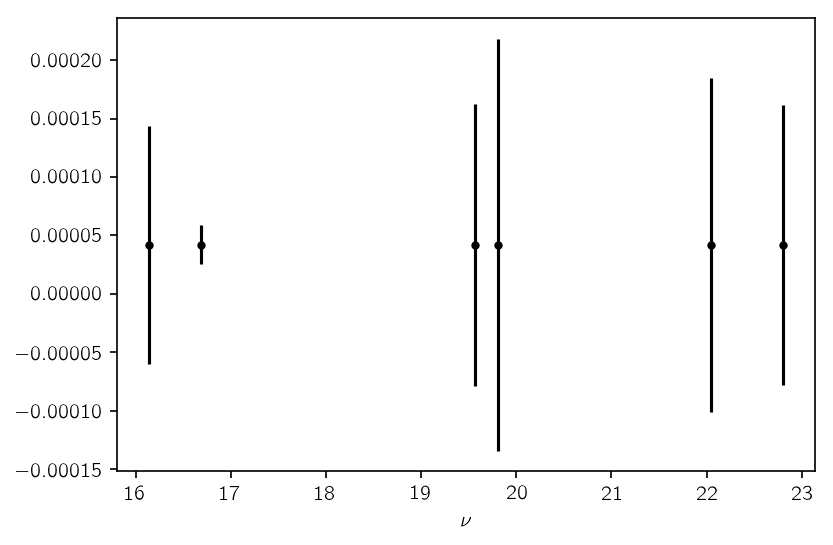

In [92]:
lt, lt_ivar = model.get_lighttime_estimates()
lt_err = np.sqrt(1./lt_ivar)
nu = model.run(model.nu)
plt.errorbar(nu, lt, yerr=lt_err, fmt="k.")
# plt.ylim(-0.01, 0.01)
plt.xlabel(r"$\nu$")

In [96]:
model.run([model.period, model.eccen, model.lighttime*86400.0])

[61.470053695998786,
 0.1791593047806834,
 array([ 3.62490676,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])]

In [94]:
orb_params

Name                   kic9837267
Porb                      61.5807
Porb_sig_p               0.423055
Porb_sig_m                0.38761
a1sini/c                  3.86971
a1sini/c_sig_p            1.23626
a1sini/c_sig_m            1.12824
e                        0.477196
e_sig_p                  0.324115
e_sig_m                  0.292347
phip                     0.054788
phip_sig_p               0.139163
phip_sig_m               0.127351
varpi                     1.65382
varpi_sig_p               0.78019
varpi_sig_m               0.71227
f(M)Msun                 1.64e-05
f(M)Msun_sig_p           1.57e-05
f(M)Msun_sig_m           1.44e-05
gradient                -0.000484
grad_sig_p               0.001484
grad_sig_m               0.001529
t_p                       54960.8
t_p_sig_p                 8.57934
t_p_sig_m                 7.85284
K1_ms                      1204.1
K1_ms_sig_p                 458.9
K1_ms_sig_m                 279.5
median_segment_size           NaN
Name: 305, dty